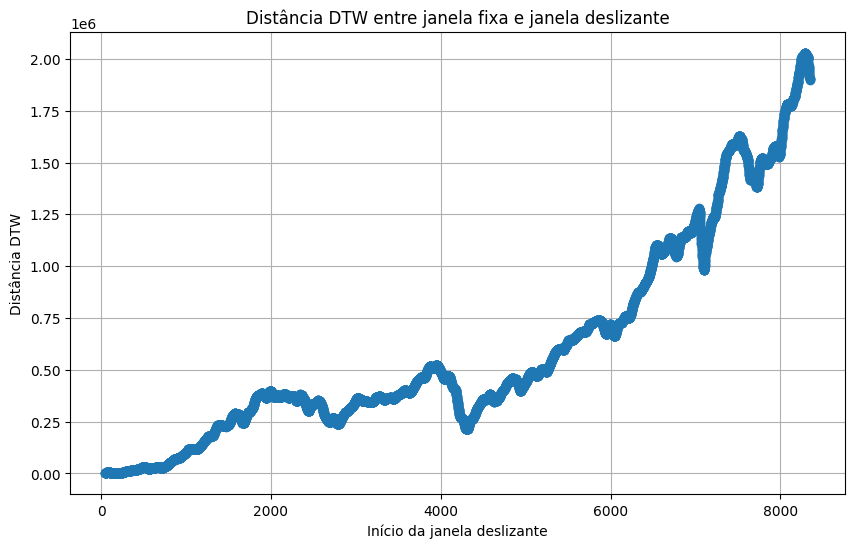

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from preprocessamento.SeriesProcessor import SeriesProcessor

# 1. Cria a série temporal
serie = SeriesProcessor.carregar_serie_csv('DJI')

# 2. Define a janela fixa (primeiras 50 observações)
window_size = 50
fixed_window = serie[:window_size]

# 3. Define a janela deslizante (também tamanho 50)
dtw_distances = []
positions = []

for i in range(window_size, len(serie) - window_size + 1):
    sliding_window = serie[i:i + window_size]
    # 4. Calcula o DTW
    distance, _ = fastdtw(fixed_window, sliding_window)
    dtw_distances.append(distance)
    positions.append(i)

# 5. Plota o gráfico
plt.figure(figsize=(10, 6))
plt.plot(positions, dtw_distances, marker='o')
plt.title('Distância DTW entre janela fixa e janela deslizante')
plt.xlabel('Início da janela deslizante')
plt.ylabel('Distância DTW')
plt.grid(True)
plt.show()

In [ ]:
#pip install dtaidistance

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Alerta na posição 21:
 - Distância DTW = 5.26
 - Pontos diferentes: [(21, 0.9231957399578224), (22, 0.8883847073668438), (23, 0.6637383979246607), (31, 0.06382808187561775), (32, -0.16319746067987304), (33, -0.37217819413929926), (34, -0.3068123765775231), (35, -0.3515635719191259), (36, -0.3356408470685521), (37, -0.42527436246828426), (38, -0.6655820111473532), (39, -0.7320902627502889), (40, -0.8746425919616896), (41, -0.9719475066461245), (42, -1.0523551250379855), (43, -0.7295343339175656), (44, -1.0091294395487107), (45, -1.025853961057341), (46, -1.1212973116372287), (47, -0.9221879186228273), (48, -1.155154298020714), (49, -0.9988367746831556), (50, -1.0410418228887008)]
--------------------------------------------------
Alerta na posição 22:
 - Distância DTW = 5.37
 - Pontos diferentes: [(22, 0.8883847073668438), (23, 0.6637383979246607), (23, 0.6637383979246607), (31, 0.06382808187561775), (32, -0.16319746067987304), (33, -0.37217819413929926), (34, -0.3068123765775231), (35,

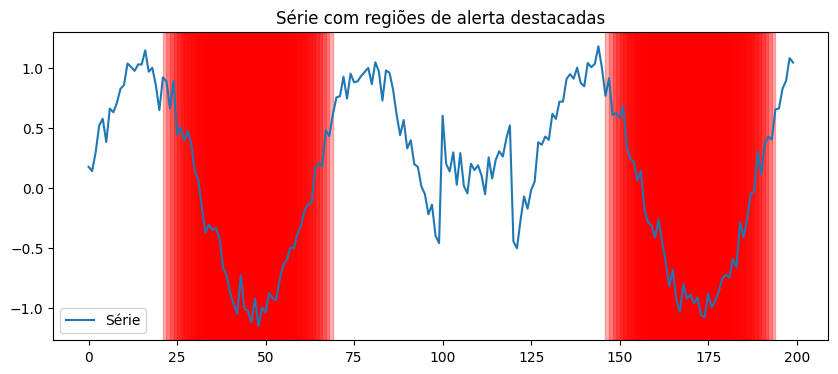

In [5]:
import numpy as np
from dtaidistance import dtw
import matplotlib.pyplot as plt

def sliding_window_dtw_alerts(series, window_size, dtw_threshold, point_threshold):
    """
    - series: sua série temporal (array-like)
    - window_size: tamanho da janela fixa e deslizante
    - dtw_threshold: limiar global de distância DTW
    - point_threshold: limiar local para considerar pontos como diferentes
    """
    fixed_window = series[:window_size]
    alerts = []

    for i in range(1, len(series) - window_size + 1):
        sliding_window = series[i:i + window_size]
        
        # DTW + caminhos de alinhamento
        distance, paths = dtw.warping_paths(fixed_window, sliding_window)
        
        if distance >= dtw_threshold:
            best_path = dtw.best_path(paths)
            different_points = []
            
            for idx_fixed, idx_sliding in best_path:
                diff = abs(fixed_window[idx_fixed] - sliding_window[idx_sliding])
                if diff >= point_threshold:
                    different_points.append((idx_sliding + i, sliding_window[idx_sliding]))
            
            alerts.append({
                'start_index': i,
                'dtw_distance': distance,
                'different_points': different_points
            })

    return alerts


# Exemplo de uso:

np.random.seed(0)
n_points = 200
series = np.sin(np.linspace(0, 20, n_points)) + np.random.normal(0, 0.1, n_points)

# Introduzir uma mudança abrupta em certo ponto para simular uma anomalia:
series[100:120] += 1.0

# Configurações
window_size = 30
dtw_threshold = 5.0
point_threshold = 0.3

# Rodar o detector
alerts = sliding_window_dtw_alerts(series, window_size, dtw_threshold, point_threshold)

# Mostrar os alertas:
for alert in alerts:
    print(f"Alerta na posição {alert['start_index']}:")
    print(f" - Distância DTW = {alert['dtw_distance']:.2f}")
    print(f" - Pontos diferentes: {alert['different_points']}")
    print('-'*50)

# Visualização (opcional)
plt.figure(figsize=(10, 4))
plt.plot(series, label='Série')
for alert in alerts:
    idx = alert['start_index']
    plt.axvspan(idx, idx + window_size, color='red', alpha=0.3)
plt.legend()
plt.title('Série com regiões de alerta destacadas')
plt.show()


In [6]:
def compare_two_windows(window1, window2, point_threshold):
    """
    Compara duas janelas usando DTW e identifica pontos diferentes na segunda janela.
    
    Parâmetros:
    - window1: array-like, primeira janela (referência)
    - window2: array-like, segunda janela (a ser comparada)
    - point_threshold: diferença mínima entre pontos para considerar como diferente
    
    Retorna:
    - dict com:
        - 'dtw_distance': distância DTW global
        - 'different_points': lista de (índice, valor) da window2 que diferem
        - 'alignment': lista de pares (idx_window1, idx_window2)
    """
    distance, paths = dtw.warping_paths(window1, window2)
    best_path = dtw.best_path(paths)
    different_points = []
    
    for idx1, idx2 in best_path:
        diff = abs(window1[idx1] - window2[idx2])
        if diff >= point_threshold:
            different_points.append((idx2, window2[idx2]))
    
    return {
        'dtw_distance': distance,
        'different_points': different_points,
        'alignment': best_path
    }


In [7]:
# Criando duas janelas para teste
w1 = np.sin(np.linspace(0, 2*np.pi, 50))
w2 = w1.copy()
w2[20:25] += 0.5  # Introduzir desvio local

# Comparar as janelas
result = compare_two_windows(w1, w2, point_threshold=0.2)

print(f"Distância DTW: {result['dtw_distance']:.2f}")
print("Pontos diferentes na segunda janela:")
for idx, val in result['different_points']:
    print(f" - Índice: {idx}, Valor: {val:.3f}")


Distância DTW: 0.51
Pontos diferentes na segunda janela:
 - Índice: 20, Valor: 1.046
 - Índice: 24, Valor: 0.564
 - Índice: 25, Valor: -0.064
